# Anomaly Detection in ECG Data
## Using Autoencoders and Threshold for Reconstruction Error

This notebook demonstrates the implementation of an unsupervised learning technique to identify anomalies in electrocardiogram (ECG) data. It has two parts:

**Autoencoder**: a neural network that learns to reconstruct normal data, identifying anomalies through reconstruction errors that exceed an optimized threshold.

**Classification based on reconstruction error**: The differences between the original data and the generated data are calculated and multiplied by a matrix of weights. From an error threshold, the data will be considered as normal or abnormal.

## Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## Exploratory data analysis

In [2]:
df = pd.read_csv('data/ecg.csv', header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,0.608558,-0.335651,-0.990948,-1.784153,-2.626145,-2.957065,-2.931897,-2.664816,-2.090137,-1.461841,...,1.757705,2.291923,2.704595,2.451519,2.017396,1.704358,1.688542,1.629593,1.342651,0.0
4994,-2.060402,-2.860116,-3.405074,-3.748719,-3.513561,-3.006545,-2.234850,-1.593270,-1.075279,-0.976047,...,1.388947,2.079675,2.433375,2.159484,1.819747,1.534767,1.696818,1.483832,1.047612,0.0
4995,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,-0.645363,...,-0.472419,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334,0.0
4996,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695270,-1.849691,-1.374321,...,1.258419,1.907530,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932,0.0


### Check Data Imbalance

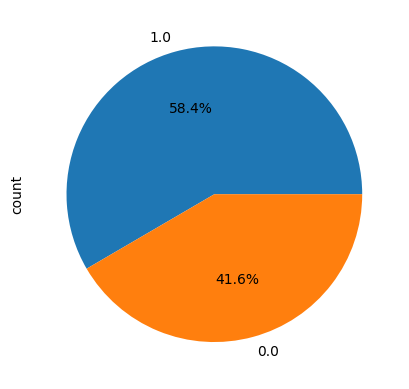

In [4]:
df[140].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.show()

### Setting X and y

In [5]:
X = df.iloc[:, 0:-1].values
y = df.iloc[:, -1].values

Min: -7.0903741
Max: 7.4021031

count    6.997200e+05
mean    -2.389455e-12
std      9.964229e-01
min     -7.090374e+00
25%     -3.048571e-01
50%      1.829281e-01
75%      5.204346e-01
max      7.402103e+00
dtype: float64


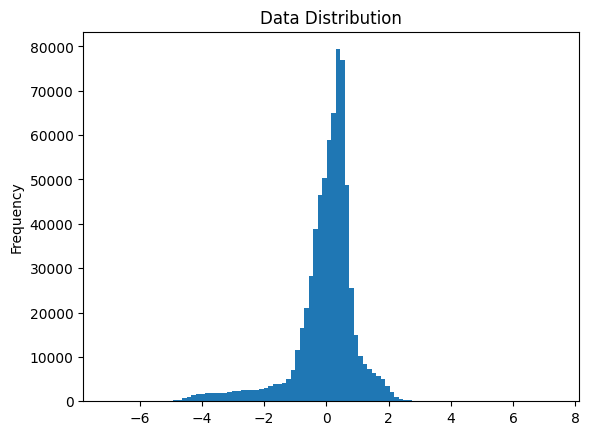

In [6]:
print("Min:", X.min())
print("Max:", X.max())
print()

X_flat_series = pd.Series(X.flatten())
print(X_flat_series.describe())
X_flat_series.plot(kind='hist', bins=100, title='Data Distribution')
plt.show()

The data found ranges from -7 to +7 and with an average very close to 0, thus, the data will be scaled from -1 to +1, facilitating the training of the autoencoder, which will have tanh as the activation function.

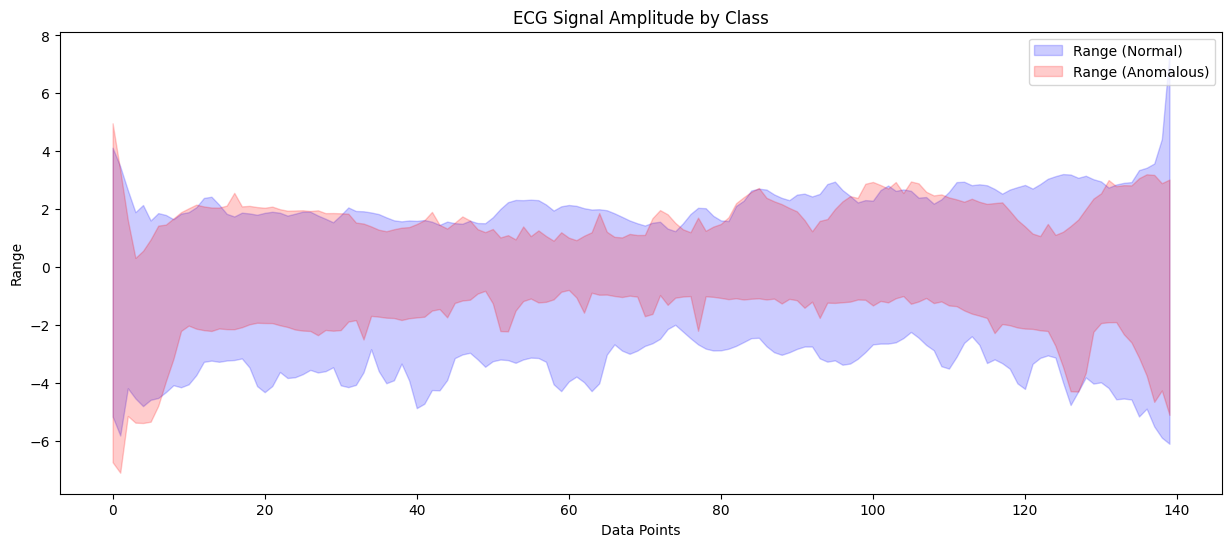

In [7]:
plt.figure(figsize=(15, 6))

plt.fill_between(
    range(140),
    np.max(X[y == 0], axis=0),
    np.min(X[y == 0], axis=0), 
    color='blue',
    alpha=0.2,
    label='Range (Normal)'
)

plt.fill_between(
    range(140),
    np.max(X[y ==1], axis=0),
    np.min(X[y ==1], axis=0), 
    color='red', alpha=0.2,
    label='Range (Anomalous)'
)

plt.title('ECG Signal Amplitude by Class')
plt.xlabel('Data Points')
plt.ylabel('Range')
plt.legend()
plt.show()

Because there are more **anomalous** samples than normal samples and there is less amplitude among the anomalous samples, an autoencoder designed to learn the **anomalous** pattern would probably perform better than an autoencoder trained based on the normal models.

On the other hand, **a normal sample considered anomalous is less worse than an anomalous sample considered normal**. Assuming that **future anomalies will not follow the same pattern**, it is better for the autoencoder to learn more about the pattern of the **normal** samples to minimize the chance of classification as an anomaly.

In [8]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)

### Splitting data

In [9]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)

print(f"Train: {X_train.shape}")
print(f"Validation: {X_val.shape}")
print(f"Test: {X_test.shape}")


Train: (2998, 140)
Validation: (1000, 140)
Test: (1000, 140)


## Model training

An **Autoencoder** is a neural network that tries to reconstruct its input data. It consists of:

- **Encoder**: compresses the input data into a lower-dimensional latent representation
- **Latent space**: composite representation of the data
- **Decoder**: reconstructs the original data from the latent representation

The idea is that the fundamental characteristics of what is being tried to be learned are learned in the latent space, so that the reconstruction is, ideally, very similar to the original data, but without sporadic randomness. This is commonly used for image noise removal.

### Operating principle for anomaly detection:
1. An autoencoder is trained only with normal (non-anomalous) examples
2. The model learns to efficiently reconstruct only normal patterns
3. When an anomaly is detected, the safety error tends to be significantly higher

In [10]:
class Autoencoder(nn.Module):
    def __init__(self, layers_dims, dropout_rate):
        super(Autoencoder, self).__init__()
        
        encoder_layers = []
        for i in range(len(layers_dims)-1):
            encoder_layers.append(nn.Linear(layers_dims[i], layers_dims[i+1]))
            encoder_layers.append(nn.BatchNorm1d(layers_dims[i+1]))
            encoder_layers.append(nn.ReLU())
            encoder_layers.append(nn.Dropout(dropout_rate))
        self.encoder = nn.Sequential(*encoder_layers)
        
        decoder_layers = []
        for i in range(len(layers_dims)-1, 0, -1):
            decoder_layers.append(nn.Linear(layers_dims[i], layers_dims[i-1]))
            if i > 1:
                decoder_layers.append(nn.BatchNorm1d(layers_dims[i-1]))
                decoder_layers.append(nn.ReLU())
                decoder_layers.append(nn.Dropout(dropout_rate))
            else:
                decoder_layers.append(nn.Tanh())
        self.decoder = nn.Sequential(*decoder_layers)
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [11]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        
        outputs = model(X)
        loss = criterion(outputs, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * X.size(0)

    return running_loss / len(dataloader.dataset)

In [12]:
def evaluate(model, dataloader, criterion, device):
        model.eval()
        running_loss = 0.0
    
        with torch.no_grad():
            for X, y in dataloader:
                X, y = X.to(device), y.to(device)
    
                outputs = model(X)
                loss = criterion(outputs, y)
                running_loss += loss.item() * X.size(0)
    
        return running_loss / len(dataloader.dataset)

In [13]:
def train(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    num_epochs,
    patience=10,
    verbose=True
):
    print("Starting training...")

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_epoch = 0

    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        train_losses.append(train_loss)
        
        val_loss = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            best_epoch = epoch + 1
            patience_counter = 0
        else:
            patience_counter += 1

        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    model.load_state_dict(torch.load('best_model.pth'))

    print(f"Best epoch: {best_epoch}")
    print("Training complete!")
    return train_losses, val_losses

In [14]:
batch_size = 256

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

X_train_tensor_normal = X_train_tensor[y_train == 0]
X_val_tensor_normal = X_val_tensor[y_val == 0]
X_test_tensor_normal = X_test_tensor[y_test == 0]

train_dataset_normal = TensorDataset(X_train_tensor_normal, X_train_tensor_normal)
val_dataset_normal = TensorDataset(X_val_tensor_normal, X_val_tensor_normal)
test_dataset_normal = TensorDataset(X_test_tensor_normal, X_test_tensor_normal)

train_loader_normal = DataLoader(train_dataset_normal, batch_size=batch_size, shuffle=True)
val_loader_normal = DataLoader(val_dataset_normal, batch_size=batch_size, shuffle=False)
test_loader_normal = DataLoader(test_dataset_normal, batch_size=batch_size, shuffle=False)

To define the autoencoder architecture, it is necessary to define the number of layers and how many neurons there will be in each one. With the `Autoencoder` class, it is possible to set this based on a list that will constitute the encoder while the decoder is the reverse list.

Considering that our input data has 140 parameters, there are some scenarios:

- **Few layers with large differences** (e.g.: `[140, 16]`): this would be a very aggressive compression, with a significant loss of information between one layer and another, which could lead to a risk of underfitting, making it difficult to capture truly useful patterns, making the model very generic.

- **Few layers with little difference** (e.g. `[140, 128]`): in this scenario, there may be insufficient compression, with a risk of overfitting, since the latent space is almost the same size as the initial number of parameters, having "space" to learn specific data and not general data, becoming a latent space with little information, which may be subject to more subtle anomalies.

- **Very gradual compression** (e.g. `[140, 128, 96, 64, 48, 32, 24, 16]`): the features are learned hierarchically, without a very large bottleneck between each layer and the next, however, because it is a deeper network, there is a greater risk of overfitting in smaller datasets and a greater probability of gradient vanishing.

Given this, `[140, 96, 48, 24]` was chosen, as it combines gradual compression without being too deep, being more controlled.

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

input_dim = X_scaled.shape[1]
layers_dims = [input_dim, 96, 48, 24]

autoencoder = Autoencoder(layers_dims, dropout_rate=0.1)
autoencoder.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

train_losses, val_losses = train(
    autoencoder, 
    train_loader_normal, 
    val_loader_normal, 
    optimizer, 
    criterion, 
    device,
    num_epochs=50
)

Starting training...
Epoch 1/50, Train Loss: 0.1968, Val Loss: 0.1173
Epoch 2/50, Train Loss: 0.1252, Val Loss: 0.0966
Epoch 3/50, Train Loss: 0.0869, Val Loss: 0.0677
Epoch 4/50, Train Loss: 0.0624, Val Loss: 0.0429
Epoch 5/50, Train Loss: 0.0484, Val Loss: 0.0304
Epoch 6/50, Train Loss: 0.0410, Val Loss: 0.0264
Epoch 7/50, Train Loss: 0.0364, Val Loss: 0.0248
Epoch 8/50, Train Loss: 0.0332, Val Loss: 0.0232
Epoch 9/50, Train Loss: 0.0303, Val Loss: 0.0216
Epoch 10/50, Train Loss: 0.0276, Val Loss: 0.0202
Epoch 11/50, Train Loss: 0.0262, Val Loss: 0.0193
Epoch 12/50, Train Loss: 0.0252, Val Loss: 0.0185
Epoch 13/50, Train Loss: 0.0247, Val Loss: 0.0177
Epoch 14/50, Train Loss: 0.0228, Val Loss: 0.0171
Epoch 15/50, Train Loss: 0.0222, Val Loss: 0.0166
Epoch 16/50, Train Loss: 0.0214, Val Loss: 0.0160
Epoch 17/50, Train Loss: 0.0217, Val Loss: 0.0153
Epoch 18/50, Train Loss: 0.0204, Val Loss: 0.0147
Epoch 19/50, Train Loss: 0.0202, Val Loss: 0.0142
Epoch 20/50, Train Loss: 0.0195, Val L

### Training Results

The loss plot shows how the reconstruction error decreases over the course of training, on both the training and validation sets. Convergence without divergence between sets indicates that the model is not suffering from significant overfitting.

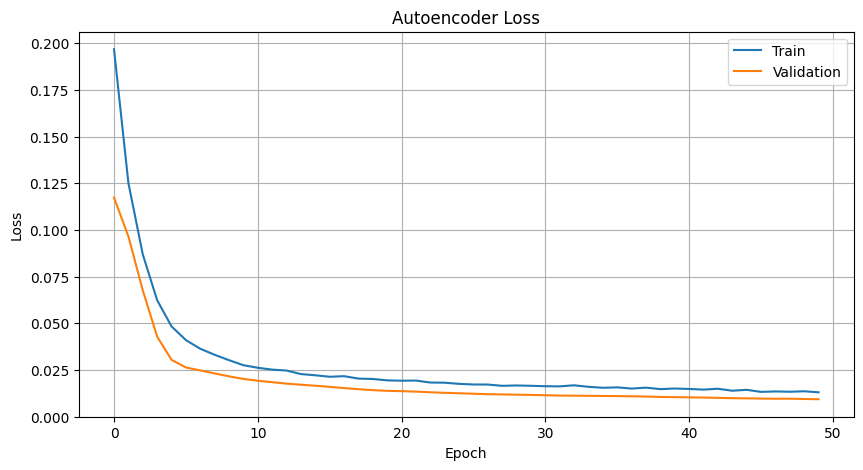

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Autoencoder Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Visualization of Reconstruction Errors

To better understand how the autoencoder differentiates between normal and anomalous ECGs, we visualize the reconstruction of some examples of each class:

In [17]:
X_train_reconstructed = autoencoder(X_train_tensor.to(device))
X_test_reconstructed = autoencoder(X_test_tensor.to(device))


*************************** NORMAL SAMPLES ***************************



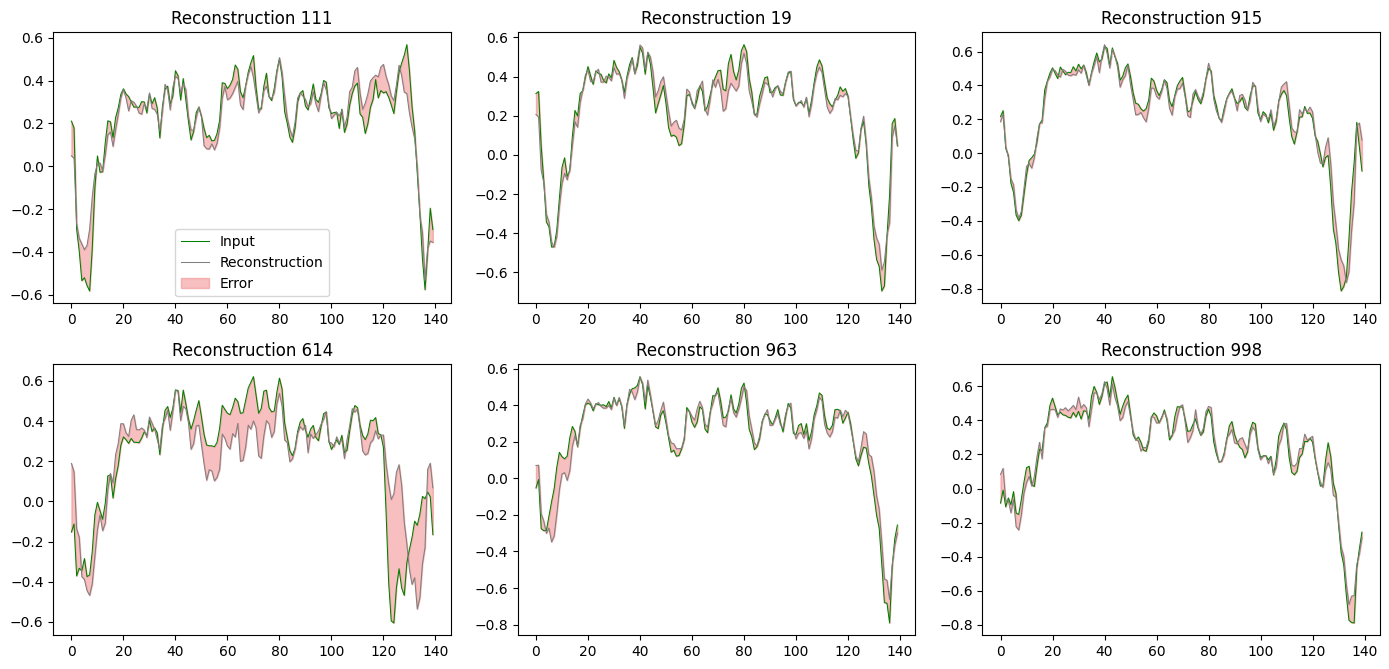


************************* ANOMALOUS SAMPLES **************************



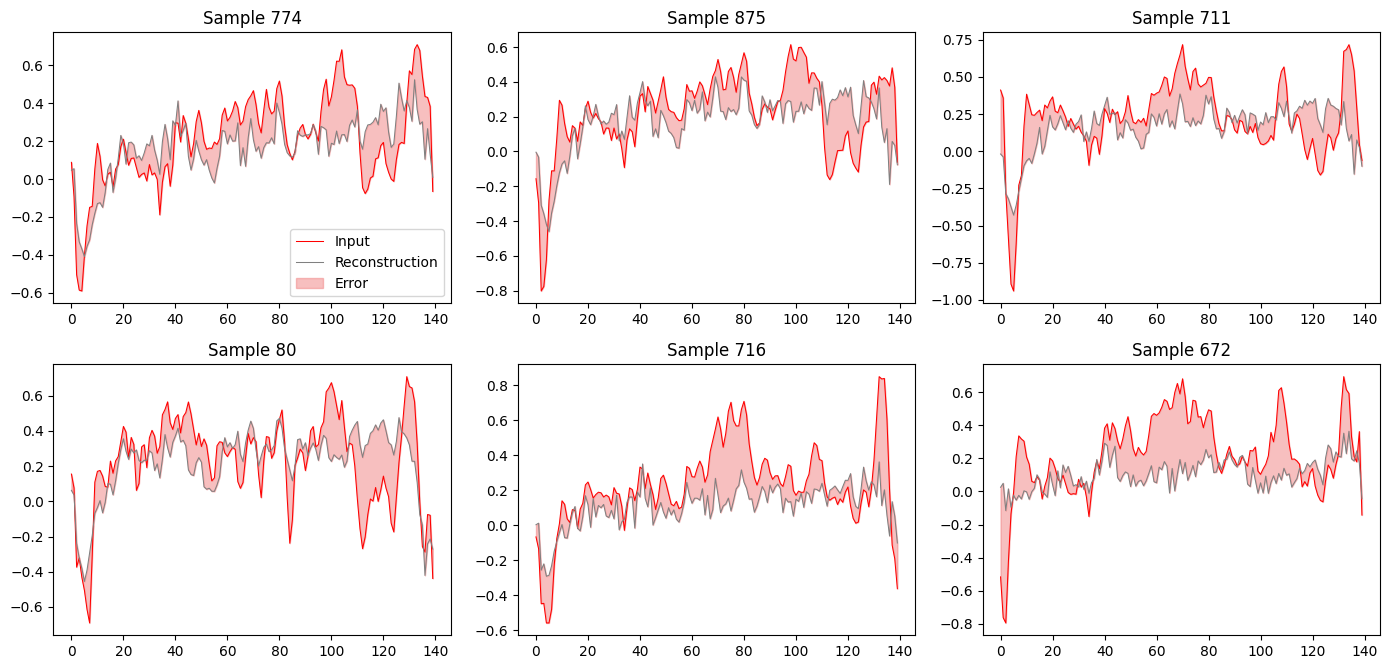

In [18]:
rows = 2
cols = 3

normal_ecg = np.where(y_test == 0)[0]
anomalous_ecg = np.where(y_test == 1)[0]

normal_indexes = random.sample(list(normal_ecg), rows * cols)
anomalous_indexes = random.sample(list(anomalous_ecg), rows * cols)

print('\n' + ' NORMAL SAMPLES '.center(70, '*') + '\n')

fig, axes = plt.subplots(rows, cols, figsize=(14, 7))
for row in range(rows):
    for col in range(cols):
        normal_sample = normal_indexes[row * cols + col]
        X_data = X_test_tensor[normal_sample].cpu().detach().numpy()
        decoded_data = X_test_reconstructed[normal_sample].cpu().detach().numpy()

        axes[row, col].plot(X_data, 'green', label="Input", linewidth=0.75)
        axes[row, col].plot(decoded_data, 'gray', label="Reconstruction", linewidth=0.75)
        axes[row, col].fill_between(np.arange(len(X_data)), decoded_data, X_data, color='lightcoral', alpha=0.5, label="Error")
        axes[row, col].set_title(f"Sample {normal_sample}")
        axes[row, col].set_title(f"Reconstruction {normal_sample}")

        if row == 0 and col == 0:
            axes[row, col].legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

print('\n' + ' ANOMALOUS SAMPLES '.center(70, '*') + '\n')

fig, axes = plt.subplots(rows, cols, figsize=(14, 7))
for row in range(rows):
    for col in range(cols):
        anomalous_sample = anomalous_indexes[row * cols + col]
        X_data = X_test_tensor[anomalous_sample].cpu().detach().numpy()
        decoded_data = X_test_reconstructed[anomalous_sample].cpu().detach().numpy()

        axes[row, col].plot(X_data, 'red', label="Input", linewidth=0.75)
        axes[row, col].plot(decoded_data, 'gray', label="Reconstruction", linewidth=0.75)
        axes[row, col].fill_between(np.arange(len(X_data)), decoded_data, X_data, color='lightcoral', alpha=0.5, label="Error")
        axes[row, col].set_title(f"Sample {anomalous_sample}")

        if row == 0 and col == 0:
            axes[row, col].legend()


plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

### Interpretation of Reconstructions

- **Normal ECGs**: We observed that the autoencoder is able to reconstruct normal ECG patterns with high fidelity, resulting in small errors (smaller red areas).

- **Anomalous ECGs**: For anomalous ECGs, the reconstructions are visibly worse, with larger errors at critical points in the signal, such as peaks and valleys.

## Error Weighting and Optimized Threshold

### Feature Importance Weighting

Not all points on an ECG are equally important for anomaly detection. Therefore, a weighting has been implemented that gives more weight to points where the reconstruction is consistently good in normal ECGs. In other words, the idea behind this is that errors that were common even in the train data will have a lower weight than errors that occurred in regions where the train data had a higher assertiveness.

In [19]:
def ensure_numpy(tensor_or_array):
    if isinstance(tensor_or_array, torch.Tensor):
        return tensor_or_array.cpu().detach().numpy()
    return tensor_or_array

def get_weights(X, X_reconstructed):
    X_np = ensure_numpy(X)
    X_rec_np = ensure_numpy(X_reconstructed)
    
    errors = np.abs(X_np - X_rec_np)
    errors_mean = np.mean(errors, axis=0) ** 2
    
    epsilon = 1e-8
    weights = 1 / (errors_mean + epsilon)
    
    return weights / np.sum(weights)

def calculate_weighted_error(X, X_reconstructed, weights):
    X_np = ensure_numpy(X)
    X_rec_np = ensure_numpy(X_reconstructed)
    
    errors = np.abs(X_np - X_rec_np)
    return np.sum(errors * weights, axis=1)

In [20]:
weights = get_weights(X_train_tensor_normal, X_train_reconstructed[y_train == 0])
errors_train = calculate_weighted_error(X_train_tensor, X_train_reconstructed, weights)
errors_test = calculate_weighted_error(X_test_tensor, X_test_reconstructed, weights)

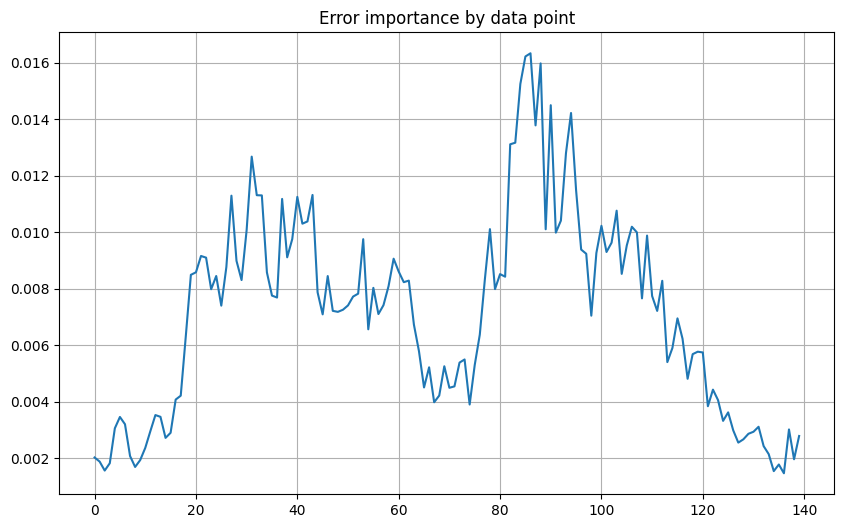

In [21]:
pd.Series(weights).plot(title='Error importance by data point', figsize=(10, 6), grid=True)
plt.show()

Just like the autoencoder, the weights were calculated based only on normal data. The graph shows the relative importance of each ECG point for anomaly detection. Points with a higher weight are those where the autoencoder can consistently reconstruct normal ECGs well, making them more discriminating for identifying anomalies.

### Determining the Optimal Threshold

To determine the ideal threshold that separates normal ECGs from anomalous ones, we use the ROC curve and the Youden index, which maximizes the sum of sensitivity and specificity:

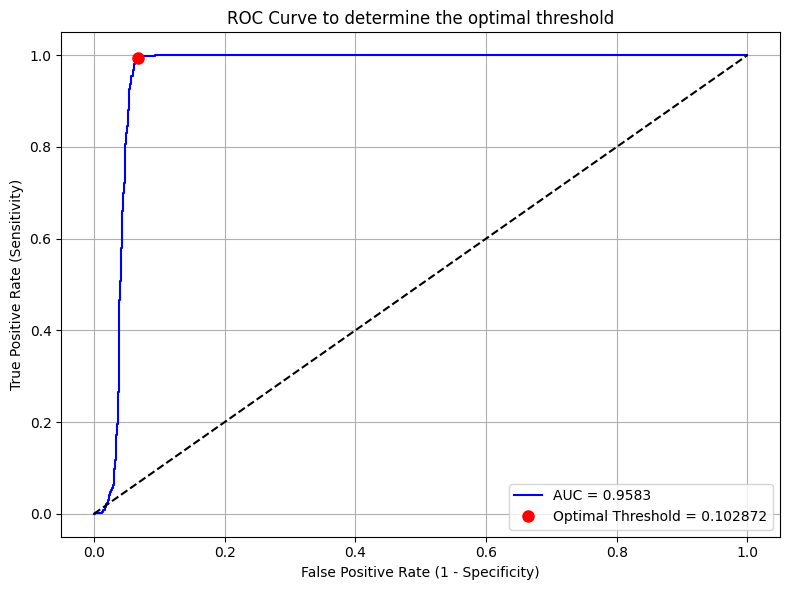

In [22]:
fpr, tpr, thresholds = roc_curve(y_train, errors_train)

J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]

y_test_pred = errors_test > optimal_threshold

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b-', label=f'AUC = {roc_auc_score(y_train, errors_train):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=8, label=f'Optimal Threshold = {optimal_threshold:.6f}')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve to determine the optimal threshold')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

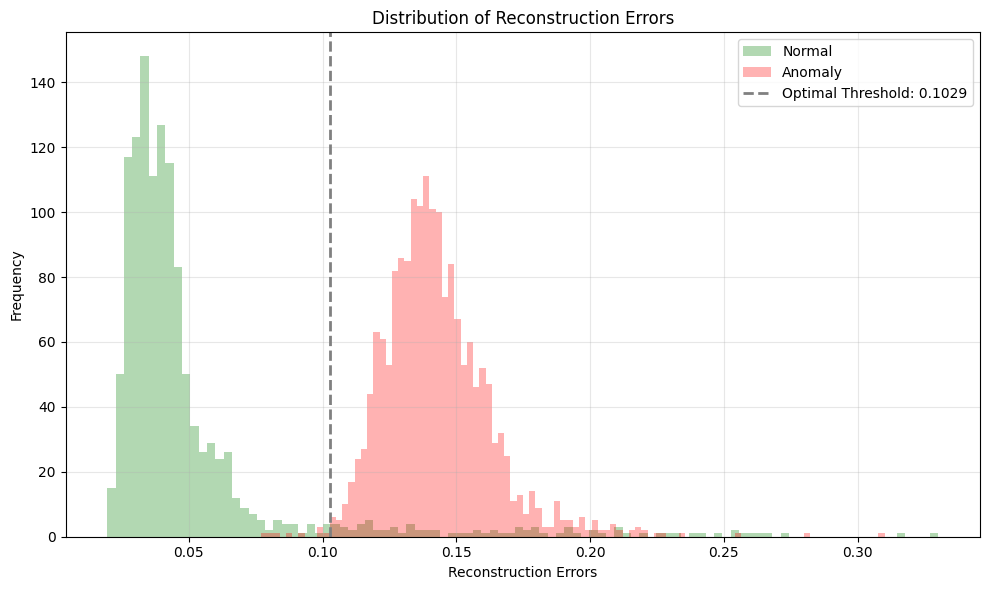

In [23]:
errors_train_normal_serie = pd.Series(errors_train[y_train == 0])
errors_train_anomalous_serie = pd.Series(errors_train[y_train == 1])

plt.figure(figsize=(10, 6))

plt.hist(errors_train_normal_serie, bins=100, alpha=0.3, label='Normal', color='green')
plt.hist(errors_train_anomalous_serie, bins=100, alpha=0.3, label='Anomaly', color='red')

plt.axvline(
    x=optimal_threshold,
    color='gray', linestyle='--', linewidth=2, 
    label=f'Optimal Threshold: {optimal_threshold:.4f}'
)

plt.xlabel('Reconstruction Errors')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Based on the ROC curve and the distribution of reconstruction errors, it is observed that there is a clear distinction between the error of normal and anomalous samples.

Accuracy: 0.9780
Precision: 0.9656
Recall: 0.9983
F1-Score: 0.9817



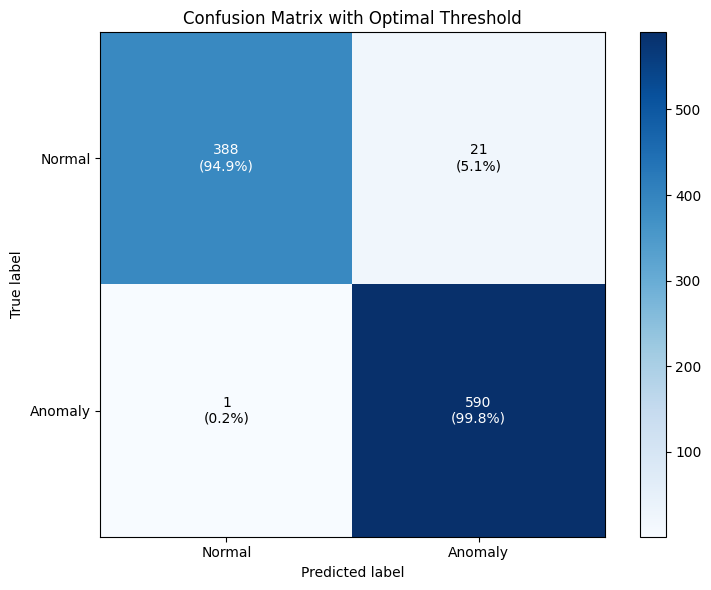

In [24]:
plt.figure(figsize=(8, 6))
ax = plt.subplot()

cm = confusion_matrix(y_test, y_test_pred)

tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print()

cm_percent = np.zeros_like(cm, dtype=float)
for i in range(cm.shape[0]):
    row_sum = np.sum(cm[i, :])
    if row_sum > 0:
        cm_percent[i, :] = cm[i, :] / row_sum * 100
    else:
        cm_percent[i, :] = 0

labels = np.array([
    [
        f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)"
        for j in range(cm.shape[1])
    ] for i in range(cm.shape[0])
])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap=plt.cm.Blues, values_format=None, ax=ax)

for text in ax.texts:
    text.remove()

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = ax.text(
            j,
            i,
            labels[i, j],
            ha="center",
            va="center", 
            color="white" if cm[i, j] > cm.max() / 2 else "black"
        )

plt.title('Confusion Matrix with Optimal Threshold')
plt.tight_layout()
plt.show()

These results are satisfactory and demonstrate the effectiveness of this approach in detecting anomalies in ECGs.

A high Recall value is particularly important in medical contexts, as it indicates that we rarely fail to identify an anomalous ECG (few false negatives).